In [4]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np

plt.style.use("ggplot")

# Generate discharge hindcast data for BEST-Siberian marine modelling

# Part 2

Aims of this notebook are to:

**2. Replace RADR modelled discharge with observations for selected rivers**
* Read in the 1980-2019 filled daily mean monthly RADR data from NB05A
* Read in monthly time series of daily mean ArcticGRO discharge observations for the six big rivers (1980-2019) from NB02.
* Area-scale ArcticGRO observations to the RADR catchment area.
* Read in data identifying which RADR catchment the ArcticGRO data corresponds to.
* Fill any gaps in ArcticGRO observations using RADR.
* Replace RADR data with (patched) ArcticGRO data.
* Do some QC

**3. Reformat RADR/obs data and add lat and long info**
* Join in lat and long info for all the radr catchments and melt into long form, ready to add Greenland data and convert to netcdf

**4. Add Greenland data**
* Read in Bamber's Greenland freshwater and ice flux data (1958 to 2016, incl.) and clean it:
    - Convert to units of m3/s    
    - Drop all before 1980
    - Reindex to full monthly series and fill NaNs with 0 for the period with modelled data (to 2016)
    - Forward fill to the end of 2019. Do this by repeating 2016 for 2017-2020. 2016 was a bit higher than the average for the period 2010-2016, but not extreme.
    - Ensure monthly indexing is the same as ArcticGRO and RADR
* Add Greenland freshwater data to the master discharge dataset

**5. Consider coastal groundwater inputs**
* Consider whether to add direct coastal groundwater inputs (see e.g. https://www.nature.com/articles/s41467-020-15250-8)

**6. Check indexing and QC ok**
* Do some QC

# Filepaths to output files and setup

In [1]:
# Filepaths to output files

obs_long_fpath = r"/home/jovyan/shared/pan_arctic_data/discharge/ArcticGRO_big6_monthly_area-scaled_radr-patched_long.csv"
obs_wide_fpath = r"/home/jovyan/shared/pan_arctic_data/discharge/ArcticGRO_big6_monthly_area-scaled_radr-patched_wide.csv"
obs_location_fpath = r"/home/jovyan/shared/pan_arctic_data/ArcticGRO_spatial_data/big_six_outflow_locations.csv"

df_long_fpath = r"/home/jovyan/shared/pan_arctic_data/discharge/FullAO_riv_discharge_monthly_long.csv"

In [2]:
# Rivers that we want to replace radr data with obs
obs_rivers = ['Yukon', 'Mackenzie', 'Ob', 'Lena', 'Kolyma', 'Yenisey']

# Dictionaries to be used later on when calculating total volumes from different sources

monthly_vol_dict = {}  # Key: col name (e.g. "big6", "gl", "fullao"),
# Returns df with index 1:12 (months), mean km3/month

annual_vol_dict = {}  # Key: index to be (e.g. "big6", "gl", "fullao")
# Returns float (total mean km3 of water per year)

# Useful functions


def reindex_fifteenth(df):
    """
    Reindex monthly time series to format yyyy-mm-15, as requested by marine
    modellers

    input: df, with datetime index at monthly frequency.
    returns: df, reindexed
    """
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = 15
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
    df = df.set_index('date')
    df.drop(['day', 'month', 'year'], axis=1, inplace=True)

    return df

# Read in filled radr data

From notebook 06a

In [5]:
# Read in filled radr data
radr_filled_fpath = r"/home/jovyan/shared/pan_arctic_data/discharge/RADR_v1_monthly_filled_1980-2019.csv"
df = pd.read_csv(radr_filled_fpath, index_col=0, parse_dates=True, infer_datetime_format=True)

# Convert column headers from string to integers
df.columns = [int(i) for i in df.columns.get_level_values(0)]

df

,25000001,25000003,25000008,25000009,25000010,25000012,25000014,25000015,25000018,25000020,...,86007262,86007263,86007264,86007266,86007268,86007270,86007271,86007272,86007273,86007275
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-31,0.414,0.821,0.011,0.102,0.049,0.007,0.153,0.055,0.082,0.200,...,0.006,0.005,0.005,0.003,0.001,0.327,0.001,0.000,0.001,0.001
1980-02-29,0.278,0.627,0.007,0.079,0.059,0.007,0.115,0.057,0.054,0.212,...,0.002,0.003,0.003,0.002,0.000,0.186,0.001,0.000,0.001,0.001
1980-03-31,0.316,0.591,0.005,0.048,0.040,0.004,0.143,0.051,0.050,0.191,...,0.001,0.002,0.002,0.001,0.000,0.133,0.001,0.000,0.000,0.001
1980-04-30,0.205,0.439,0.004,0.033,0.023,0.003,0.102,0.031,0.050,0.119,...,0.001,0.002,0.002,0.001,0.000,0.106,0.000,0.000,0.000,0.001
1980-05-31,4.514,6.886,0.056,0.647,1.373,0.142,1.685,1.103,0.757,2.895,...,0.255,0.662,1.285,0.365,0.224,0.557,0.068,0.190,0.155,0.318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-31,21.086,92.355,16.413,12.975,8.372,4.170,13.274,11.908,61.359,19.910,...,2.222,1.799,2.398,1.107,0.623,2.595,0.341,0.379,0.467,0.693
2019-09-30,12.019,49.890,3.072,3.939,1.690,1.981,9.955,4.352,15.835,4.422,...,0.795,0.436,0.439,0.213,0.091,3.524,0.065,0.039,0.074,0.113
2019-10-31,11.651,43.544,0.438,1.164,0.402,0.575,9.047,1.616,3.257,1.436,...,0.401,0.054,0.053,0.027,0.007,1.892,0.011,0.004,0.011,0.011


# Read in shapefiles with location info for ArcticGRO and RADR catchments, and to link ArcticGRO and RADR

Read in the shapefile derived in notebook 03_join_radr_and_obs, which includes column "OutCOMID" to identify which RADR catchment each ArcticGRO gauging station corresponds to.

We don't want to use all the ArcticGRO rivers when replacing RADR. As discussed in notebook 04_compare_radr_and_obs, for now we I have decided to just use the big 6. So cut down obs_gdf to just those rivers

In [6]:
obs_shp_fpath = r"/home/jovyan/shared/pan_arctic_data/ArcticGRO_spatial_data/sampling_locations_discharge_one-site-per-riv.shp"
obs_gdf = gpd.read_file(obs_shp_fpath)
obs_gdf.set_index('NameTidy', drop=False, inplace=True)
obs_gdf = obs_gdf.loc[obs_rivers, :]

# Reset index to COMID for interaction with RADR
obs_gdf.set_index('OutCOMID', inplace=True)

obs_gdf

,River,Sampling_l,Lat,Lon,Collection,data_downl,area_STN_k,area_GRDC_,ContPerma_,ContDiscon,popdensity,comment,NameTidy,radr_area_,geometry
OutCOMID,,,,,,,,,,,,,,,
81020021,Yukon,Pilot Station,61.93,-162.88,USGS,1,850596,831390,19.0,87.0,0.2,None,Yukon,8.362082e+05,POINT (6124999.301 4816953.001)
82000867,Mackenzie,Arctic Red River,67.45,-133.74,Water Survery of Canada,1,1678481,1660000,13.0,42.0,0.2,None,Mackenzie,1.791398e+06,POINT (4662256.962 4890571.113)
31006084,Ob',Salekhard,66.63,66.60,Roshydromet,1,2533000,2950000,1.0,4.0,8.0,None,Ob,2.945383e+06,POINT (4547667.559 138911.561)
34000655,Lena,Kyusyur,70.68,127.39,Roshydromet,1,2430000,2430000,77.0,90.0,0.4,kyusyur not in GRDC database. Area from https:...,Lena,2.464300e+06,POINT (6074074.943 1857686.726)
35006945,Kolyma,Kolymskoe,68.73,158.72,Roshydromet,1,536000,526000,99.0,100.0,0.1,None,Kolyma,6.531339e+05,POINT (6373420.329 2985244.110)
32000794,Yenisey,Igarka,67.43,86.48,Roshydromet,1,2413000,2440000,31.0,42.0,3.0,None,Yenisey,2.569614e+06,POINT (5311240.594 484778.545)


To convert RADR from wide to long format, also need lat and long info for all COMIDs

In [7]:
# Read in shapefile with lat and long of all RADR catchment outlets
radr_pt_shp = f"~/shared/pan_arctic_data/merit_hydro_basins/radr_outlets_merged.shp"
radr_pt_df = gpd.read_file(radr_pt_shp)

# Drop the geometry info to reduce size in memory
radr_pt_df = pd.DataFrame(radr_pt_df.drop(columns='geometry'))
radr_pt_df.set_index('OutCOMID', inplace=True)

# Change lat and lon to have 5 d.p. precision (around 1 m at the equator)
radr_pt_df = radr_pt_df.round(5)

radr_pt_df.head()

,lon,lat
OutCOMID,,
25000001,26.34417,80.17500
25000003,24.42167,80.24917
25000008,19.23167,80.08583
25000009,22.49167,80.02750
25000010,23.07417,80.11250


In [8]:
# Make a little clean df of Arctic River lat and longs, with river as index,
# for easy joining to the main dataframe
# Use RADR lat/longs, NOT ArcticGRO monitoring point locations
obs_location_df = obs_gdf[['NameTidy']]
obs_location_df.columns = ['river']

obs_location_df = obs_location_df.merge(radr_pt_df, how='left',
                                        left_index=True, right_index=True)

# Also write this to csv, may be useful for marine modellers instead of long format
obs_location_df.to_csv(obs_location_fpath, index_label='OutCOMID')

obs_location_df

,river,lon,lat
OutCOMID,,,
81020021,Yukon,-164.61917,63.03500
82000867,Mackenzie,-136.10417,68.89000
31006084,Ob,69.84750,66.46000
34000655,Lena,129.09833,72.03250
35006945,Kolyma,161.70583,69.49833
32000794,Yenisey,83.34833,70.97833


# Read in ArcticGRO observations and area-scale

Read in the monthly ArcticGRO data for the rivers of interest (from notebook 02), and then area-scale it to the RADR catchment areas. 

N.B. discussion point is how applicable this area-scaling is, given likely big differences in catchment characteristics and weather between the ungauged part of the catchment (Arctic) and the rest of the catchment.

In [9]:
q_cleaned_monthly_folder = r'/home/jovyan/shared/pan_arctic_data/discharge/ArcticGRO/data/cleaned_monthly'

file_list = os.scandir(q_cleaned_monthly_folder)
q_obs_dict = {}  # Key: river name, returns series of Q

# Read in Q obs
for item in file_list:
    if item.is_file():  # Otherwise get e.g. ipython checkpoints too
        riv_name = item.name.split('_')[0]

        if riv_name in obs_rivers:
            q_series = pd.read_csv(item, index_col=0, parse_dates=True)
            q_obs_dict[riv_name] = q_series

# Concatenate all rivs into one df and check looks ok
raw_obs_df = pd.concat(q_obs_dict, axis=1)
raw_obs_df = raw_obs_df.droplevel(1, axis=1).sort_index(axis=1)
raw_obs_df.head()

,Kolyma,Lena,Mackenzie,Ob,Yenisey,Yukon
date,,,,,,
1980-01-31,144.032258,3922.580645,2941.935484,6928.387097,7701.290323,1913.774194
1980-02-29,140.652087,2780.689655,2871.034483,5370.689655,8130.689655,1723.482759
1980-03-31,234.331482,2009.354839,2701.612903,4284.838710,7659.032258,1607.774194
1980-04-30,199.879759,1606.333333,2648.666667,3874.000000,7745.333333,1443.333333
1980-05-31,195.775462,3270.967742,13867.419355,16670.967742,14365.161290,10116.387097


In [10]:
# Area-scale (manually checked for a couple of rivers and looks good)
scaled_obs_df = pd.DataFrame(index=raw_obs_df.index)
cat_ids = obs_gdf.index

for com_id in cat_ids:
    river = obs_gdf.loc[com_id, 'NameTidy']
    q_original = raw_obs_df[river]

    radr_area = obs_gdf['radr_area_'][com_id]
    obs_area = obs_gdf['area_GRDC_'][com_id]

    # The Ob' area at the gauging site is given to be slightly larger than the
    # MERIT-Hydro area. If this is the case (more generally), then don't area-scale
    if obs_area >= radr_area:
        q_scaled = q_original
    else:
        q_scaled = q_original * obs_gdf['radr_area_'][com_id]/obs_gdf['area_GRDC_'][com_id]

    q_scaled = q_scaled.values
    scaled_obs_df[river] = q_scaled

scaled_obs_df = scaled_obs_df.sort_index(axis=1)
scaled_obs_df.head()

,Kolyma,Lena,Mackenzie,Ob,Yenisey,Yukon
date,,,,,,
1980-01-31,178.844769,3977.948675,3174.804979,6928.387097,8110.387133,1924.865259
1980-02-29,174.647613,2819.939659,3098.291795,5370.689655,8562.596396,1733.471011
1980-03-31,290.969261,2037.717294,2915.459616,4284.838710,8065.884297,1617.091870
1980-04-30,248.190578,1629.007057,2858.322410,3874.000000,8156.769733,1451.698011
1980-05-31,243.094275,3317.138122,14965.097724,16670.967742,15128.246620,10175.015490


# Fill remaining gaps in Arctic GRO then replace RADR data for selected rivers

First need to fill any remaining gaps in the ArcticGRO data. Small gaps were already interpolated in notebook 02_observed_discharge. Here, I fill any larger gaps using the RADR data.

**Future improvement**: for now, I just fill NaNs using raw RADR data. However, a future improvement would be to bias correct the RADR data using the observations first.

Then, once we have a full time series for all the ArcticGRO rivers, just overwrite data in the radr dataframe using the observed, area-scaled discharge.

<Axes: xlabel='Date'>

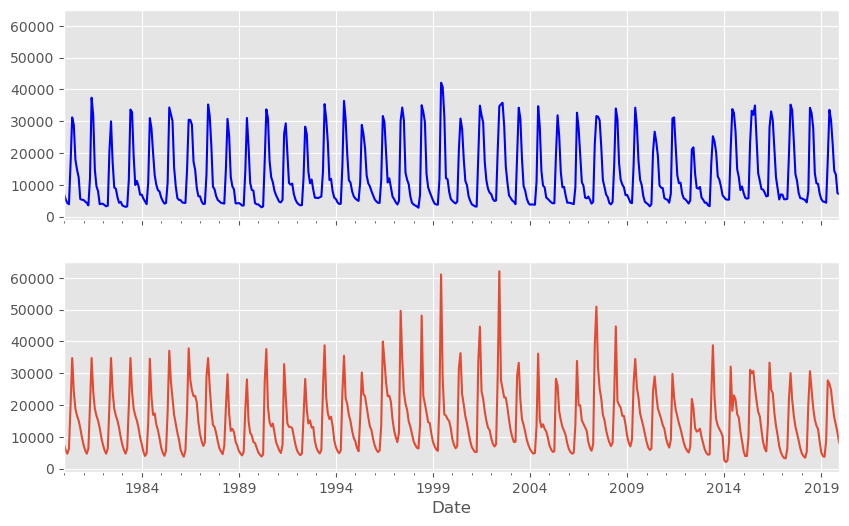

In [11]:
# First, quick plot of RADR and Obs for an example river, the Ob (OutCOMID 31006084)
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 6))
scaled_obs_df['Ob'].plot(ax=axs[0], color='b')
radr_ts = df[31006084]
radr_ts.plot(ax=axs[1])

Yukon:
Indices for radr and obs are the same: True
Number of NaNs to fill: 54
NaNs after filling: 0
Mackenzie:
Indices for radr and obs are the same: True
Number of NaNs to fill: 0
Ob:
Indices for radr and obs are the same: True
Number of NaNs to fill: 0
Lena:
Indices for radr and obs are the same: True
Number of NaNs to fill: 0
Kolyma:
Indices for radr and obs are the same: True
Number of NaNs to fill: 0
Yenisey:
Indices for radr and obs are the same: True
Number of NaNs to fill: 0


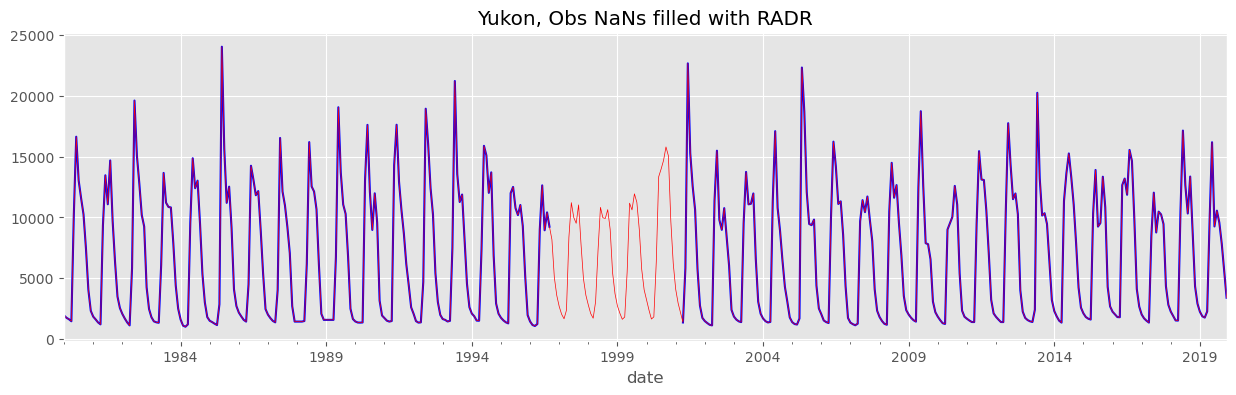

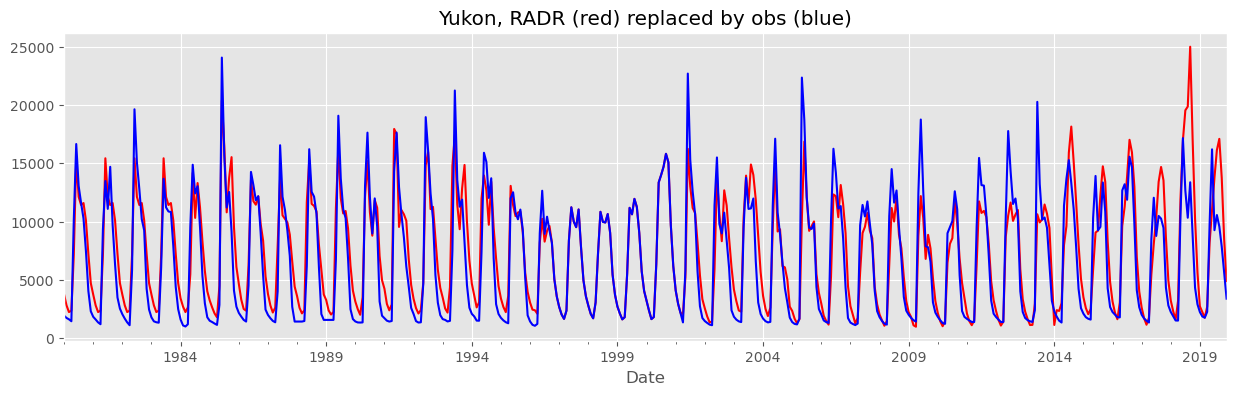

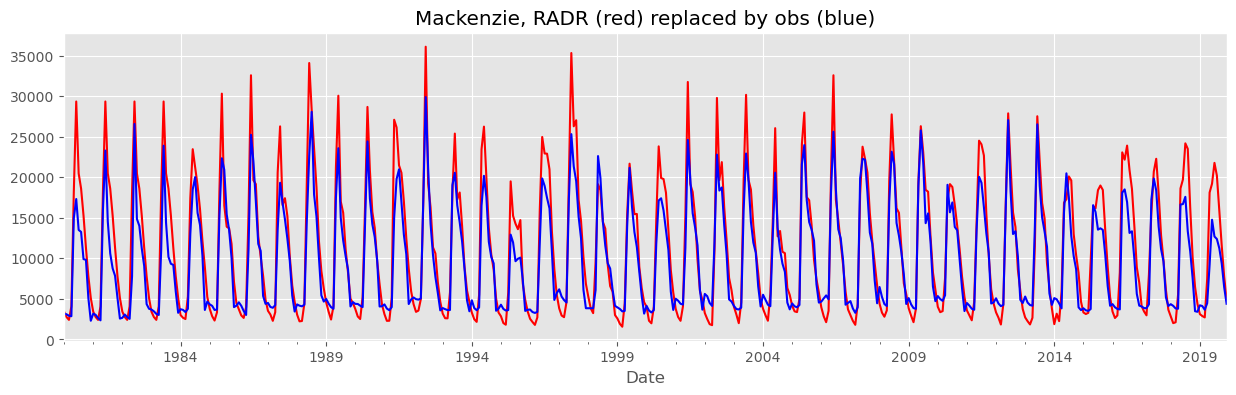

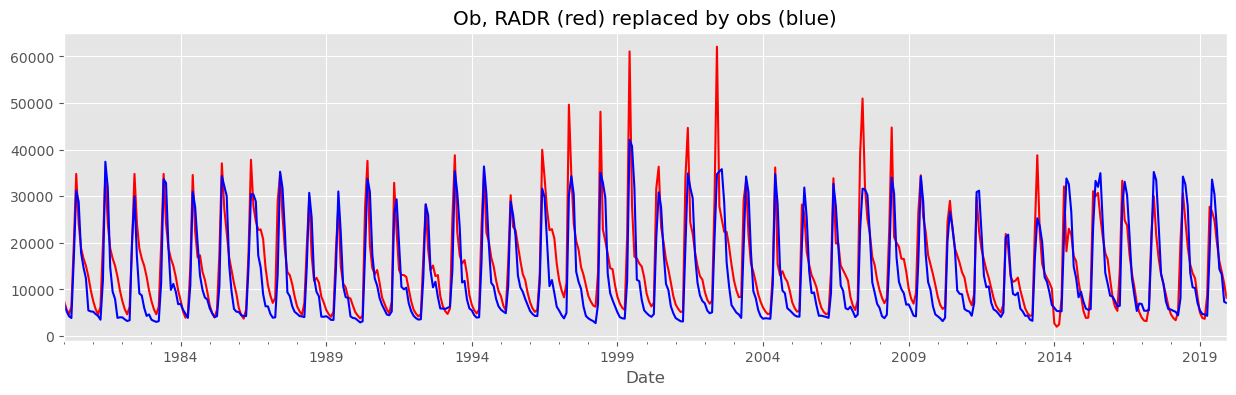

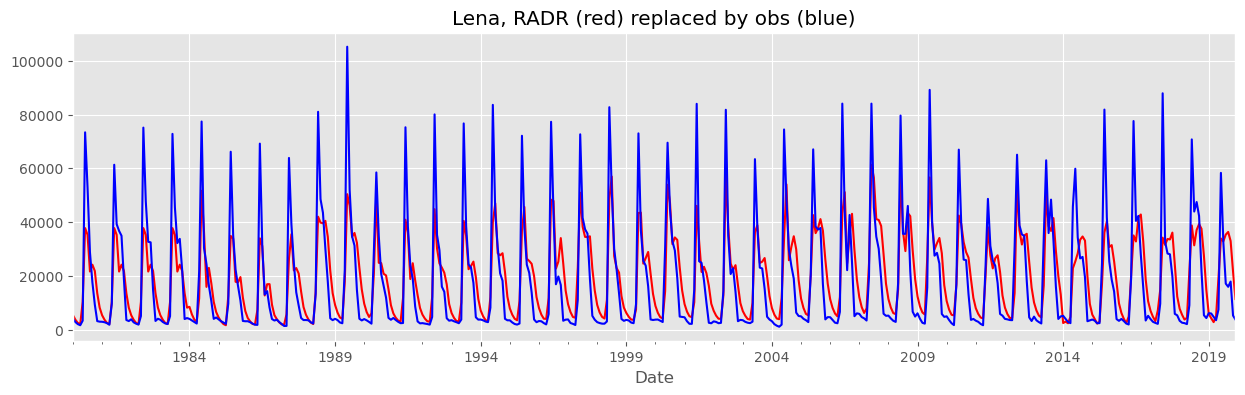

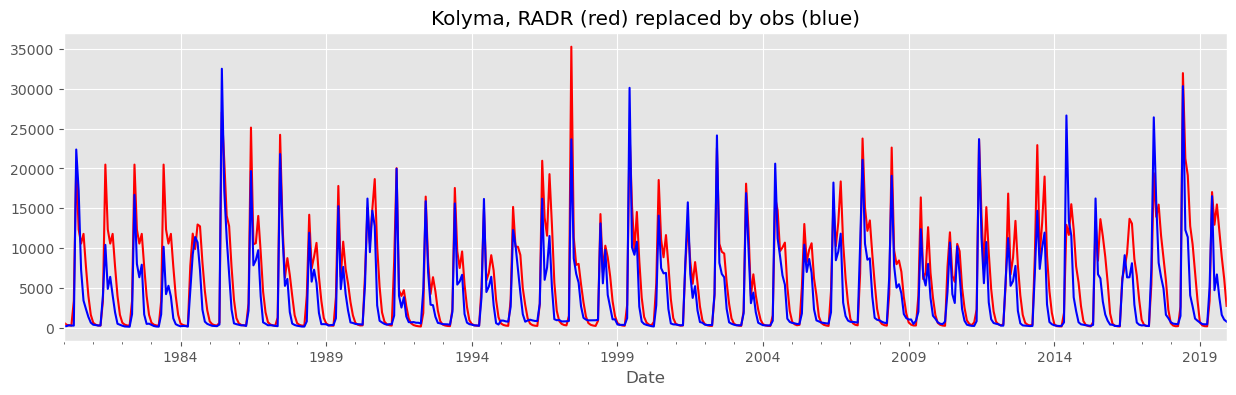

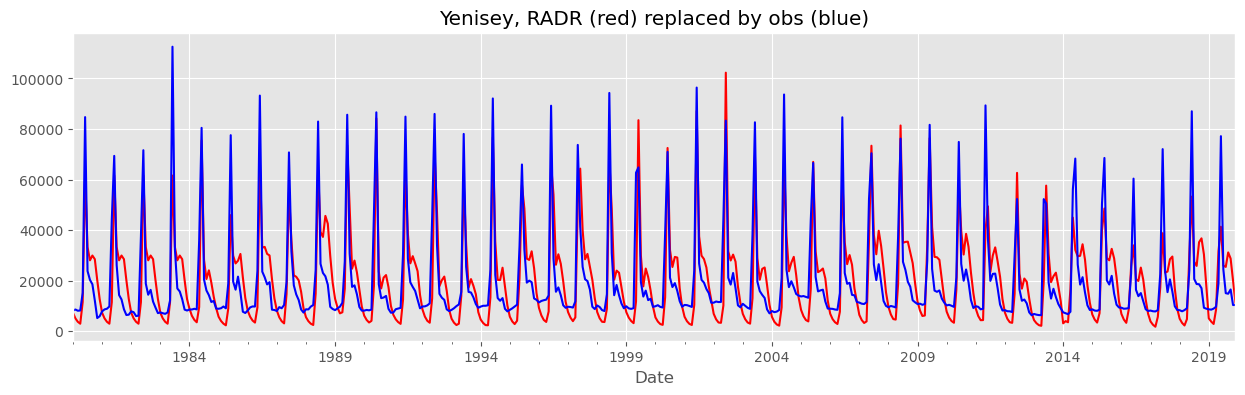

In [12]:
# The catchments to replace with observed data
cat_ids = obs_gdf.index

for com_id in cat_ids:
    riv_name = obs_gdf.loc[com_id, 'NameTidy']
    print("%s:" % riv_name)

    # First make sure the observed indices match the radr ones
    idx_obs = scaled_obs_df[riv_name].index
    idx_radr = df.index
    print("Indices for radr and obs are the same: %s" % idx_obs.equals(idx_radr))

    # Then fill any NAs in the observed data using RADR
    # (for the big 6, this should only be the case for the Yukon)
    nans_to_fill = scaled_obs_df[riv_name].isna().sum()
    print("Number of NaNs to fill: %s" % nans_to_fill)

    if nans_to_fill > 0:
        fig, ax1 = plt.subplots()
        scaled_obs_df[riv_name].plot(ax=ax1, figsize=(15, 4), color='b')
        scaled_obs_df[riv_name].fillna(df[com_id], inplace=True)
        print("NaNs after filling: %s" % scaled_obs_df[riv_name].isna().sum())

        scaled_obs_df[riv_name].plot(ax=ax1, color='r', linewidth=0.5)
        plt.title("%s, Obs NaNs filled with RADR" % riv_name)

    # Then replace data in the radr df directly, with plot of before and after
    # for checking
    fig2, ax2 = plt.subplots()
    df[com_id].plot(ax=ax2, color='r', figsize=(15, 4))
    df[com_id] = scaled_obs_df[riv_name]
    df[com_id].plot(color='b', ax=ax2)
    plt.title("%s, RADR (red) replaced by obs (blue)" % riv_name)

**QC**

Big differences for some. I have checked against notebook 04_compare_radr_obs, and all is correct.

## Write cleaned/patched ArcticGRO data to a single csv for marine modelling

Quick summary of what this data is:

- ArcticGRO data, monthly mean of daily means
- Small gaps interpolated
- Larger gaps (Yukon only) filled with RADR data
- Area-scaled to match the area of the associated RADR catchment (i.e. hopefully the whole area that runs to the sea)
- Latitude and longitudes are associated with the RADR catchment outlet, **NOT the ArcticGRO monitoring point**


In [13]:
# Reindex to 15th day of each month and save wide to csv
scaled_obs_df = reindex_fifteenth(scaled_obs_df)
scaled_obs_df = scaled_obs_df.round(2)  # Drop unnecessary decimals

# Save
scaled_obs_df.to_csv(obs_wide_fpath)

scaled_obs_df

,Kolyma,Lena,Mackenzie,Ob,Yenisey,Yukon
date,,,,,,
1980-01-15,178.84,3977.95,3174.80,6928.39,8110.39,1924.87
1980-02-15,174.65,2819.94,3098.29,5370.69,8562.60,1733.47
1980-03-15,290.97,2037.72,2915.46,4284.84,8065.88,1617.09
1980-04-15,248.19,1629.01,2858.32,3874.00,8156.77,1451.70
1980-05-15,243.09,3317.14,14965.10,16670.97,15128.25,10175.02
...,...,...,...,...,...,...
2019-08-15,6673.93,17112.38,12381.18,23038.71,15015.46,10558.09
2019-09-15,3807.88,15921.61,11234.15,14390.00,14796.34,9576.21
2019-10-15,1592.22,17867.40,9343.46,13209.68,16483.04,7840.56


In [14]:
# Convert to long format
obs_df_long = scaled_obs_df.copy()
obs_df_long.reset_index(inplace=True)

obs_df_long = pd.melt(obs_df_long, id_vars='date', value_vars=obs_rivers,
                      var_name="river",
                      value_name="discharge_cumecs")

# Add lat and long info to the long df
obs_df_long = obs_df_long.merge(obs_location_df,
                                left_on='river', right_on='river',
                                left_index=False, right_index=False)

# Reorder column names
obs_df_long = obs_df_long.reindex(columns=['lat', 'lon', 'river', 'date', 'discharge_cumecs'])

# Write to csv
obs_df_long.to_csv(obs_long_fpath, index=False)

obs_df_long

,lat,lon,river,date,discharge_cumecs
0,63.03500,-164.61917,Yukon,1980-01-15,1924.87
1,63.03500,-164.61917,Yukon,1980-02-15,1733.47
2,63.03500,-164.61917,Yukon,1980-03-15,1617.09
3,63.03500,-164.61917,Yukon,1980-04-15,1451.70
4,63.03500,-164.61917,Yukon,1980-05-15,10175.02
...,...,...,...,...,...
2875,70.97833,83.34833,Yenisey,2019-08-15,15015.46
2876,70.97833,83.34833,Yenisey,2019-09-15,14796.34
2877,70.97833,83.34833,Yenisey,2019-10-15,16483.04
2878,70.97833,83.34833,Yenisey,2019-11-15,10325.85


## Calculate total water volumes from the big 6

In [15]:
obs_monthly_volume_df = pd.DataFrame(index=scaled_obs_df.index)

# Convert from m3/s to km3/month
for col in scaled_obs_df:
    obs_monthly_volume_df[col] = scaled_obs_df[col] * scaled_obs_df.index.days_in_month * 86400 / 10**9  # km3/month

mean_month_obs_df = obs_monthly_volume_df.groupby(obs_monthly_volume_df.index.month).mean()
mean_month_obs_df

,Kolyma,Lena,Mackenzie,Ob,Yenisey,Yukon
date,,,,,,
1,1.283331,10.659904,12.016956,14.547415,24.373955,5.299175
2,0.995153,7.984593,10.096426,11.475805,22.425597,4.039801
3,0.982047,7.036208,10.296735,11.360278,24.421067,3.875801
4,0.946425,5.791198,10.220034,11.698081,24.446725,3.837707
5,8.199118,36.069033,40.915393,46.661024,90.418451,23.979151
6,45.835336,191.445043,55.724938,84.207612,198.651033,40.770631
7,22.444147,106.355505,47.878194,76.728924,64.899209,32.787823
8,19.301313,78.141485,38.355799,54.408584,46.114447,30.374416
9,17.356410,67.273963,31.790054,32.782190,46.328045,28.165332


In [16]:
# Then sum across rivers to get monthly total from the big 6 (km3/month)
big6_monthly_vol_df = mean_month_obs_df.sum(axis=1)
monthly_vol_dict["big6"] = big6_monthly_vol_df
print(big6_monthly_vol_df)

# And sum all together to get annual mean vol from the big 6 (km3/yr)
big6_mean_annual_vol = big6_monthly_vol_df.sum()
annual_vol_dict["big6"] = big6_mean_annual_vol
print("\n Mean annual vol from big 6: %s" % round(big6_mean_annual_vol, 1))  # km3/yr

date
1      68.180735
2      57.017374
3      57.972138
4      56.940170
5     246.242171
6     616.634593
7     351.093801
8     266.696044
9     223.695994
10    166.354131
11     83.840051
12     69.632698
dtype: float64

 Mean annual vol from big 6: 2264.3


## Calculate total water volumes from the full RADR dataset excluding Greenland

(Manually checked two catchments in excel - looks good)

In [17]:
radr_li = []

# Convert from m3/s to km3/month
for col in df.columns:
    monthly_total_s = pd.Series(index=df.index,
                                data=df[col] * df.index.days_in_month * 86400 / 10**9,
                                name=col)
    radr_li.append(monthly_total_s)

mean_monthly_radr_df = pd.concat(radr_li, axis=1)
del radr_li

# Calculate monthly mean total volume over all years (km3/month)
mean_monthly_radr_df = mean_monthly_radr_df.groupby(mean_monthly_radr_df.index.month).mean()
mean_monthly_radr_df

,25000001,25000003,25000008,25000009,25000010,25000012,25000014,25000015,25000018,25000020,...,86007262,86007263,86007264,86007266,86007268,86007270,86007271,86007272,86007273,86007275
Date,,,,,,,,,,,,,,,,,,,,,
1,0.006221,0.007152,0.000039,0.000299,0.000162,0.000031,0.002082,0.000178,0.000312,0.000614,...,0.000014,0.000012,0.000012,0.000007,2.142720e-06,0.000659,0.000003,3.348000e-07,3.013200e-06,0.000003
2,0.005694,0.004918,0.000040,0.000267,0.000218,0.000038,0.001708,0.000191,0.000393,0.000630,...,0.000005,0.000007,0.000007,0.000004,6.264000e-08,0.000346,0.000002,0.000000e+00,2.380320e-06,0.000002
3,0.004892,0.003392,0.000024,0.000140,0.000059,0.000013,0.001300,0.000070,0.000189,0.000301,...,0.000003,0.000005,0.000005,0.000003,0.000000e+00,0.000276,0.000002,0.000000e+00,6.696000e-07,0.000003
4,0.003478,0.002005,0.000014,0.000092,0.000037,0.000007,0.000844,0.000041,0.000105,0.000198,...,0.000005,0.000048,0.000047,0.000031,6.609600e-06,0.000213,0.000005,2.151360e-05,1.224720e-05,0.000034
5,0.009286,0.010331,0.000104,0.000767,0.001616,0.000142,0.002874,0.001505,0.001336,0.003786,...,0.000546,0.001728,0.002206,0.000921,4.088578e-04,0.000971,0.000144,3.549550e-04,2.547828e-04,0.000705
6,0.054546,0.157758,0.005262,0.020210,0.025991,0.008516,0.022075,0.020091,0.041020,0.046920,...,0.002624,0.006630,0.008389,0.003695,1.713895e-03,0.003721,0.000736,1.420157e-03,1.353478e-03,0.002466
7,0.021489,0.096711,0.016147,0.016624,0.011588,0.007155,0.010372,0.009417,0.079817,0.025323,...,0.002042,0.004348,0.005893,0.002437,1.167648e-03,0.003621,0.000569,8.248133e-04,8.023147e-04,0.001666
8,0.018482,0.064515,0.010575,0.009521,0.007455,0.002717,0.009174,0.007877,0.045697,0.017398,...,0.004177,0.005630,0.007334,0.003046,1.404955e-03,0.005595,0.000637,1.006342e-03,9.979049e-04,0.002037
9,0.018222,0.054431,0.002565,0.006374,0.006358,0.002257,0.008922,0.005763,0.016074,0.013867,...,0.002692,0.002663,0.003271,0.001419,6.226632e-04,0.006312,0.000318,4.146552e-04,4.401216e-04,0.000888


In [18]:
# Then sum across rivers (rows) to get monthly total from all RADR catchments (km3/month)
mean_monthly_radr_df = mean_monthly_radr_df.sum(axis=1)
monthly_vol_dict["radr"] = mean_monthly_radr_df
print(mean_monthly_radr_df)

# And sum across months together to get annual mean vol from all RADR catchments (km3/yr)
radr_mean_annual_vol = mean_monthly_radr_df.sum()
annual_vol_dict["radr"] = radr_mean_annual_vol
print("\n Mean annual vol from radr (excl. GL): %s" % round(radr_mean_annual_vol, 1))  # km3/yr

Date
1      117.328191
2       92.376986
3       90.259525
4      103.111293
5      447.635168
6     1196.047375
7      752.525570
8      531.057778
9      454.716684
10     336.074890
11     190.099280
12     140.951509
dtype: float64

 Mean annual vol from radr (excl. GL): 4452.2


# Convert filled RADR Q from wide to long format and add lat and lon

In [19]:
# Convert filled RADR+ArcticGRO to long format
df_long_noGL = df.copy()
df_long_noGL = df_long_noGL.round(2)  # Drop unnecessary decimals

value_vars = df.columns.values

df_long_noGL.reset_index(inplace=True)

df_long_noGL = pd.melt(df_long_noGL, id_vars='Date', value_vars=value_vars,
                       var_name="OutCOMID",
                       value_name="discharge_cumecs")

# Add lat and long info to the long df
df_long_noGL = df_long_noGL.merge(radr_pt_df,
                                  left_on='OutCOMID',
                                  left_index=False, right_index=True)

# Reorder column names
df_long_noGL = df_long_noGL.reindex(columns=['lat', 'lon', 'OutCOMID', 'Date', 'discharge_cumecs'])
df_long_noGL.rename(columns={'Date': 'date'}, inplace=True)

df_long_noGL

,lat,lon,OutCOMID,date,discharge_cumecs
0,80.17500,26.34417,25000001,1980-01-31,0.41
1,80.17500,26.34417,25000001,1980-02-29,0.28
2,80.17500,26.34417,25000001,1980-03-31,0.32
3,80.17500,26.34417,25000001,1980-04-30,0.20
4,80.17500,26.34417,25000001,1980-05-31,4.51
...,...,...,...,...,...
5115835,74.40917,-112.70083,86007275,2019-08-31,0.69
5115836,74.40917,-112.70083,86007275,2019-09-30,0.11
5115837,74.40917,-112.70083,86007275,2019-10-31,0.01
5115838,74.40917,-112.70083,86007275,2019-11-30,0.00


## Bit of QC

Group by lat and lon and look at number of records. See that there are 16 sets of points which have different COMIDs but the same outlet lat and lon (as calculated by James). I have manually checked a couple of these, and they are ok. It's just due to the resolution of the underlying data (coastline, catchment boundaries, river network), and seems to be when (a) the two catchments join each other so they do have the same outflow more or less, or else they almost do but the underlying data isn't quite right. Good enough though. But means that can't group by just lat and lon. Need to use COMID too.

In [21]:
same_comid_li = []

for i, group in enumerate(df_long_noGL.groupby(by=['lat', 'lon'])):
    cur_df = group[1]

    # Set COMID, or a new id for greenland inputs. Each will be a col in the main df
    if cur_df['OutCOMID'].isnull().values.any():
        riv_id = "GL%s" %i
    else:
        riv_id = cur_df['OutCOMID'].iloc[0]

    if len(cur_df) > 480:
        same_comid_li.append([riv_id, cur_df['OutCOMID'].iloc[-1]])

same_comid_li

[[26010395, 26010850],
 [83009375, 83009622],
 [85006402, 85006552],
 [83007078, 83007127],
 [81005819, 81006156],
 [26002229, 26002239],
 [82000100, 82000110],
 [35005360, 35005397],
 [82000057, 82000072],
 [26000912, 26000958],
 [26000675, 26000709],
 [86005086, 86005235],
 [86004804, 86004828],
 [33000750, 33000798],
 [86004482, 86004545],
 [86000045, 86000078]]

# Read in and process Greenland freshwater flux data and add to RADR

In [22]:
gl_runoff_fpath = r"~/shared/pan_arctic_data/freshwater_flux_from_terrestrial_ice/bamber_2016/greenland_discharge_tidy.csv"
gl_df_raw = pd.read_csv(gl_runoff_fpath)
gl_df_raw.head()

,lon,lat,date,days_in_month,runoff_ice_km3,runoff_tundra_km3,solid_ice_km3,runoff_total_km3
0,-72.931712,78.157519,1958-07-01,31,0.0,0.02,0.0,0.02
1,-72.931712,78.157519,1958-08-01,31,0.0,0.01,0.0,0.01
2,-72.931712,78.157519,1959-06-01,30,0.0,0.01,0.0,0.01
3,-72.931712,78.157519,1959-07-01,31,0.0,0.02,0.0,0.02
4,-72.931712,78.157519,1959-08-01,31,0.0,0.01,0.0,0.01


In [23]:
# Add mean runoff per month in cumecs (m3/sec)
gl_df_raw["discharge_cumecs"] = (
    gl_df_raw["runoff_total_km3"]  # km3/month
    * (1 / gl_df_raw["days_in_month"])  # month/days
    * (1 / 86400)  # day/second
    * 10**9
)  # m3/km3

# Round lat and lon to 5 d.p. (same as I did for RADR)
gl_df_raw[['lon', 'lat']] = gl_df_raw[['lon', 'lat']].round(5)

# Drop unwanted columns, to reduce the file size in memory when I come to
# add the full monthly time series
gl_df_raw = gl_df_raw[["lon", "lat", "date", "discharge_cumecs"]]

# Drop all dates before 1980
gl_df_raw = gl_df_raw.query("date >= '1980-01-01'")

gl_df_raw.head()

,lon,lat,date,discharge_cumecs
38,-72.93171,78.15752,1980-07-01,3.733572
39,-72.93171,78.15752,1981-06-01,3.858025
40,-72.93171,78.15752,1981-07-01,7.467145
41,-72.93171,78.15752,1982-06-01,3.858025
42,-72.93171,78.15752,1982-07-01,3.733572


In [24]:
# Now re-index using the full monthly time series, 1980-2019
# This generates NaNs, which should be dealt with:
#   before 2016: fill with 0s
#   after 2016: fill with the monthly value from 2016

dates_original = pd.date_range("1980-01-01", "2016-12-01", freq="MS")  # "MS" freq is left-closed
all_dates = pd.date_range("1980-01-01", "2019-12-01", freq="MS")
n_yrs_to_repeat = 3

df_list = []
gl_groups = gl_df_raw.groupby(['lon', 'lat'])

for i, grp in enumerate(gl_groups):
    cur_df = grp[1][['date', 'discharge_cumecs']]
    cur_df.set_index(pd.to_datetime(cur_df['date']), inplace=True)
    cur_df = cur_df.drop(['date'], axis=1)

    # Reindex and fill NaNs with 0
    cur_df = cur_df.reindex(dates_original, fill_value=0)

    # Reindex using the full dates, and fill 2017-2019
    # with 12 last values repeated
    fill_values = n_yrs_to_repeat * list(cur_df.iloc[-12:]['discharge_cumecs'].values)
    fill_idx = all_dates[-12*n_yrs_to_repeat:]
    fill_rows_df = pd.DataFrame(data=fill_values, index=fill_idx, columns=["discharge_cumecs"])
    cur_df = pd.concat([cur_df, fill_rows_df], axis=0)

    # Add lat and lon info back in from the group label
    cur_df['lon'] = grp[0][0].copy()
    cur_df['lat'] = grp[0][1].copy()

    cur_df.index.name = 'date'
    cur_df.reset_index(inplace=True)

    # Join to copy of dates df to get all dates with NaNs
    df_list.append(cur_df)

# Overwrite gl_df with the full concatenated set of data
gl_df = pd.concat(df_list, axis='rows')
del df_list  # Clear from memory
gl_df

,date,discharge_cumecs,lon,lat
0,1980-01-01,0.000000,-72.93171,78.15752
1,1980-02-01,0.000000,-72.93171,78.15752
2,1980-03-01,0.000000,-72.93171,78.15752
3,1980-04-01,0.000000,-72.93171,78.15752
4,1980-05-01,0.000000,-72.93171,78.15752
...,...,...,...,...
475,2019-08-01,7.467145,-11.70735,81.32108
476,2019-09-01,0.000000,-11.70735,81.32108
477,2019-10-01,0.000000,-11.70735,81.32108
478,2019-11-01,0.000000,-11.70735,81.32108


## Quick check of results

Text(0, 0.5, 'Monthly mean flow (m3/s)')

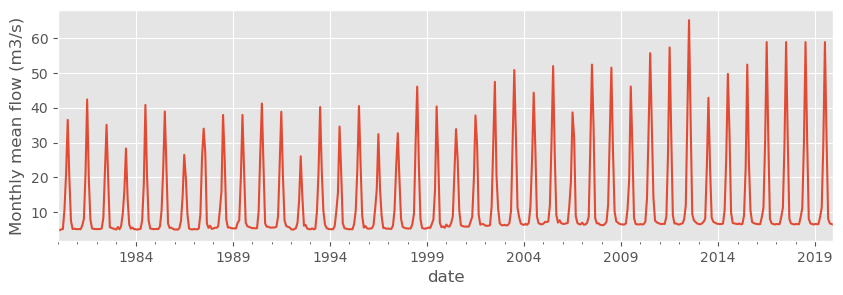

In [25]:
# Plot monthly mean for all Greenland points
gl_df.groupby("date").mean()['discharge_cumecs'].plot(figsize=(10, 3))
plt.ylabel("Monthly mean flow (m3/s)")

## Calculate total annual volumes from GL

Find that when group by lat and lon, don't have any groups where the number of data rows is over 480. i.e. all points are uniquely located (unlike the RADR outlets, where two catchments can have the same outlet due to poor resolution of the coastline, catchment boundaries and/or river locations.).

In [26]:
gl_series_li = []

for i, group in enumerate(gl_df.groupby(by=['lat', 'lon'])):
    cur_df = group[1]
    gl_id = "GL%s" % i

    # if len(cur_df) > 480:
        # warning, return error

    cur_df.set_index(pd.to_datetime(cur_df['date']), inplace=True)
    cur_df = cur_df[['discharge_cumecs']]

    if i == 0:
        # print(group[0])
        # Make master dataframe to be populated
        gl_monthly_volume_df = pd.DataFrame(index=cur_df.index)

    # Convert from m3/s to km3/month
    monthly_total_s = pd.Series(index=cur_df.index,
                                data=cur_df['discharge_cumecs'] * cur_df.index.days_in_month * 86400 / 10**9,
                                name=gl_id)
    gl_series_li.append(monthly_total_s)

gl_monthly_volume_df = pd.concat(gl_series_li, axis=1)
del gl_series_li

gl_monthly_volume_df = gl_monthly_volume_df.groupby(gl_monthly_volume_df.index.month).mean()
gl_monthly_volume_df

,GL0,GL1,GL2,GL3,GL4,GL5,GL6,GL7,GL8,GL9,...,GL2382,GL2383,GL2384,GL2385,GL2386,GL2387,GL2388,GL2389,GL2390,GL2391
date,,,,,,,,,,,,,,,,,,,,,
1,0.00000,0.00100,0.00000,0.00000,0.00050,0.00100,0.00925,0.00475,0.00000,0.00575,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,0.00025,0.00050,0.00000,0.00000,0.00050,0.00050,0.00600,0.00325,0.00000,0.00375,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,0.00025,0.00050,0.00000,0.00000,0.00050,0.00050,0.00550,0.00225,0.00000,0.00250,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,0.00050,0.00225,0.00000,0.00000,0.00125,0.00200,0.00875,0.00725,0.00000,0.00825,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
5,0.00650,0.01775,0.00375,0.00150,0.01300,0.01800,0.04075,0.03075,0.00125,0.03825,...,0.00125,0.00000,0.00000,0.00125,0.00125,0.00025,0.00075,0.00000,0.00075,0.00000
6,0.01025,0.03525,0.01250,0.00900,0.02150,0.04650,0.08950,0.07975,0.00900,0.07875,...,0.01950,0.00925,0.00725,0.02975,0.01650,0.00675,0.01650,0.00825,0.01375,0.00750
7,0.00200,0.01775,0.00625,0.00425,0.00725,0.02775,0.03875,0.05800,0.01175,0.04425,...,0.01450,0.01825,0.01100,0.06025,0.01500,0.00125,0.01400,0.01000,0.00450,0.00125
8,0.00000,0.00675,0.00025,0.00025,0.00200,0.01075,0.01200,0.02375,0.00550,0.02275,...,0.00200,0.00300,0.00150,0.02050,0.00200,0.00000,0.00025,0.00550,0.00000,0.00000
9,0.00050,0.00650,0.00025,0.00000,0.00275,0.00875,0.01175,0.01550,0.00250,0.01400,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [27]:
# Then group by outflow (across rows) to get monthly totals (km3/month)
gl_monthly_volume_df = gl_monthly_volume_df.sum(axis=1)
monthly_vol_dict["GL"] = gl_monthly_volume_df
print(gl_monthly_volume_df)

# And sum all together to get annual mean vol for all GL (km3/yr)
gl_mean_annual_vol = gl_monthly_volume_df.sum()
annual_vol_dict["GL"] = gl_mean_annual_vol
print("\n Mean annual vol from GL: %s" % round(gl_mean_annual_vol, 1))  # km3/yr

date
1      37.943326
2      34.626641
3      37.987551
4      41.268226
5      64.363601
6     147.316399
7     279.176872
8     162.446499
9      53.234526
10     40.864201
11     38.495851
12     38.279876
dtype: float64

 Mean annual vol from GL: 976.0


Compared to the plot of monthly totals in NB04, this looks sensible: increase in recent years, and 2012 had the highest runoff_ice of the series.

## Add GL data to radr + arcticGRO df and standardise date formats

Current date formatting:
- RADR and ArcticGRO: monthly value stored against last day of month
- Greenland: value stored against first day of month

Phil/Andre marine modelling: use 15th day of the month.

In [28]:
print(len(gl_df))
print(len(df_long_noGL))

1148160
5115840


In [29]:
df_long_noGL.head()

,lat,lon,OutCOMID,date,discharge_cumecs
0,80.175,26.34417,25000001,1980-01-31,0.41
1,80.175,26.34417,25000001,1980-02-29,0.28
2,80.175,26.34417,25000001,1980-03-31,0.32
3,80.175,26.34417,25000001,1980-04-30,0.20
4,80.175,26.34417,25000001,1980-05-31,4.51


In [30]:
gl_df.head()

,date,discharge_cumecs,lon,lat
0,1980-01-01,0.0,-72.93171,78.15752
1,1980-02-01,0.0,-72.93171,78.15752
2,1980-03-01,0.0,-72.93171,78.15752
3,1980-04-01,0.0,-72.93171,78.15752
4,1980-05-01,0.0,-72.93171,78.15752


In [31]:
# Concatenate RADR (+ArcticGRO) and Greenland data
df_long = pd.concat([df_long_noGL, gl_df], axis=0, ignore_index=True)
df_long

,lat,lon,OutCOMID,date,discharge_cumecs
0,80.17500,26.34417,25000001,1980-01-31,0.410000
1,80.17500,26.34417,25000001,1980-02-29,0.280000
2,80.17500,26.34417,25000001,1980-03-31,0.320000
3,80.17500,26.34417,25000001,1980-04-30,0.200000
4,80.17500,26.34417,25000001,1980-05-31,4.510000
...,...,...,...,...,...
6263995,81.32108,-11.70735,NaN,2019-08-01,7.467145
6263996,81.32108,-11.70735,NaN,2019-09-01,0.000000
6263997,81.32108,-11.70735,NaN,2019-10-01,0.000000
6263998,81.32108,-11.70735,NaN,2019-11-01,0.000000


In [32]:
# Convert dates to format YYYY-MM-15
df_long = df_long.set_index('date')
df_long = reindex_fifteenth(df_long)
df_long = df_long.reset_index()
# df_long['date'] = df_long['date'].dt.strftime('%Y-%m')

print(len(df_long))
df_long

6264000


,date,lat,lon,OutCOMID,discharge_cumecs
0,1980-01-15,80.17500,26.34417,25000001,0.410000
1,1980-02-15,80.17500,26.34417,25000001,0.280000
2,1980-03-15,80.17500,26.34417,25000001,0.320000
3,1980-04-15,80.17500,26.34417,25000001,0.200000
4,1980-05-15,80.17500,26.34417,25000001,4.510000
...,...,...,...,...,...
6263995,2019-08-15,81.32108,-11.70735,NaN,7.467145
6263996,2019-09-15,81.32108,-11.70735,NaN,0.000000
6263997,2019-10-15,81.32108,-11.70735,NaN,0.000000
6263998,2019-11-15,81.32108,-11.70735,NaN,0.000000


In [33]:
df_long.to_csv(df_long_fpath, index=False)

# Compare volumes

Compare total annual water volumes to the AO from:
* the big 6
* GL
* radr (with and without the big 6)

Check these roughly match literature values.

In [34]:
# monthly total volumes
monthly_vol_df = pd.concat(monthly_vol_dict, axis=1)
monthly_vol_df["small_radr_rivs"] = monthly_vol_df["radr"] - monthly_vol_df["big6"]
monthly_vol_df["full_ao"] = monthly_vol_df["radr"] + monthly_vol_df["GL"]
monthly_vol_df.drop("radr", axis=1, inplace=True)
monthly_vol_df

,big6,GL,small_radr_rivs,full_ao
1,68.180735,37.943326,49.147456,155.271517
2,57.017374,34.626641,35.359612,127.003627
3,57.972138,37.987551,32.287387,128.247076
4,56.940170,41.268226,46.171124,144.379519
5,246.242171,64.363601,201.392998,511.998769
6,616.634593,147.316399,579.412782,1343.363774
7,351.093801,279.176872,401.431769,1031.702442
8,266.696044,162.446499,264.361734,693.504277
9,223.695994,53.234526,231.020690,507.951210
10,166.354131,40.864201,169.720759,376.939091


Text(0, 0.5, 'Discharge to AO, km3/month')

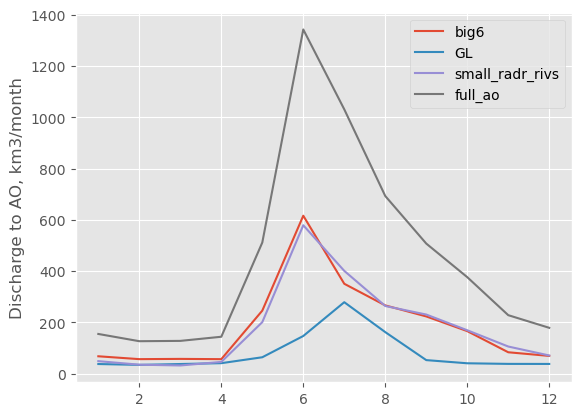

In [35]:
monthly_vol_df.plot()
plt.ylabel("Discharge to AO, km3/month")

In [36]:
monthly_pc_df = pd.DataFrame(index=monthly_vol_df.index)
for col in monthly_vol_df:
    monthly_pc_df[col] = 100 * monthly_vol_df[col] / monthly_vol_df["full_ao"]
monthly_pc_df = monthly_pc_df.round(1)
monthly_pc_df

,big6,GL,small_radr_rivs,full_ao
1,43.9,24.4,31.7,100.0
2,44.9,27.3,27.8,100.0
3,45.2,29.6,25.2,100.0
4,39.4,28.6,32.0,100.0
5,48.1,12.6,39.3,100.0
6,45.9,11.0,43.1,100.0
7,34.0,27.1,38.9,100.0
8,38.5,23.4,38.1,100.0
9,44.0,10.5,45.5,100.0
10,44.1,10.8,45.0,100.0


Text(0, 0.5, 'Discharge to AO, % of total')

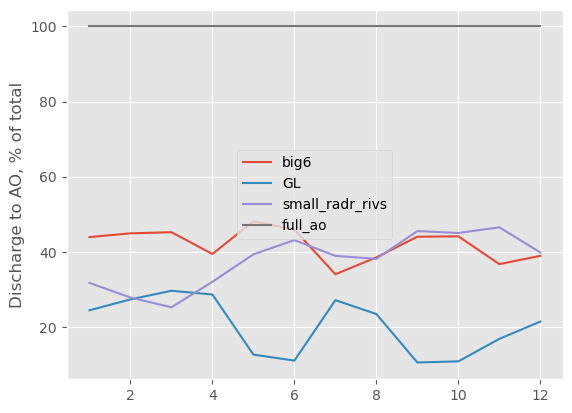

In [37]:
monthly_pc_df.plot()
plt.ylabel("Discharge to AO, % of total")

In [38]:
# annual total volumes
annual_s = pd.Series(annual_vol_dict)
annual_s.name = "annual_vol_km3"
annual_s["small_radr_rivs"] = annual_s["radr"] - annual_s["big6"]
annual_s["full_ao"] = annual_s["radr"] + annual_s["GL"]
annual_df = annual_s.to_frame()
annual_df

,annual_vol_km3
big6,2264.299899
radr,4452.184248
GL,976.003571
small_radr_rivs,2187.884349
full_ao,5428.187819


In [39]:
# add annual %s from each source
annual_df["percent total"] = np.NaN
for index in annual_df.index:
    annual_df.loc[index, "percent total"] = (
        100
        * annual_df.loc[index, "annual_vol_km3"]
        / annual_df.loc["full_ao", "annual_vol_km3"]
    )
annual_df = annual_df.round(2)
annual_df

,annual_vol_km3,percent total
big6,2264.30,41.71
radr,4452.18,82.02
GL,976.00,17.98
small_radr_rivs,2187.88,40.31
full_ao,5428.19,100.00


**Comparison to literature values**

Fang et al. (2021), the authors of the RADR study, say:
* Based on RADR, the average freshwater export to the Arctic Ocean is 5,169 km3/yr, ranging from 4,656–6,073 km3/yr
* Average runoff 234 mm/year

Same order of magnitude, but lower than my number by a worrying amount given it's supposed to be exactly the same data, apart from: 
1) I replaced their big 6 catchs with Arctic GRO. Did RADR simulations over-estimate compared to ArcticGRO?
To test: repeat without replacing big 6 catchments with observations. Find: radr annual_vol_km3 = 4725 (that was before I filled using just the first 5 start or end years; will be a little lower now), so within their max/min range, though still on the low side (missing 444 km3/yr)
2) James identified the marine outlet points, and may have done so differently to them (identified fewer??). Will talk to James about.

Elsewhere, people say that the big 6 rivers account for about 60% of the total runoff, but that was using a smaller catchment area than the RADR one and excluding GL. So looks about right on that front too.

The Greenland totals look good compared to Bamber et al. (2018) reported values.

Overall, looks ok, though I'm not entirely satisfied with my RADR total being under the Fang one.